In [3]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# II- Download the reference table
w_land = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/w_land.csv')

#  wlands16 Backup
wlands = w_land.copy()

# # VI Convert the df into geopandas df
wlands['geometry'] = wlands['geometry'].apply(wkt.loads)
wlands = gpd.GeoDataFrame(wlands, geometry='geometry')



pandas.core.frame.DataFrame

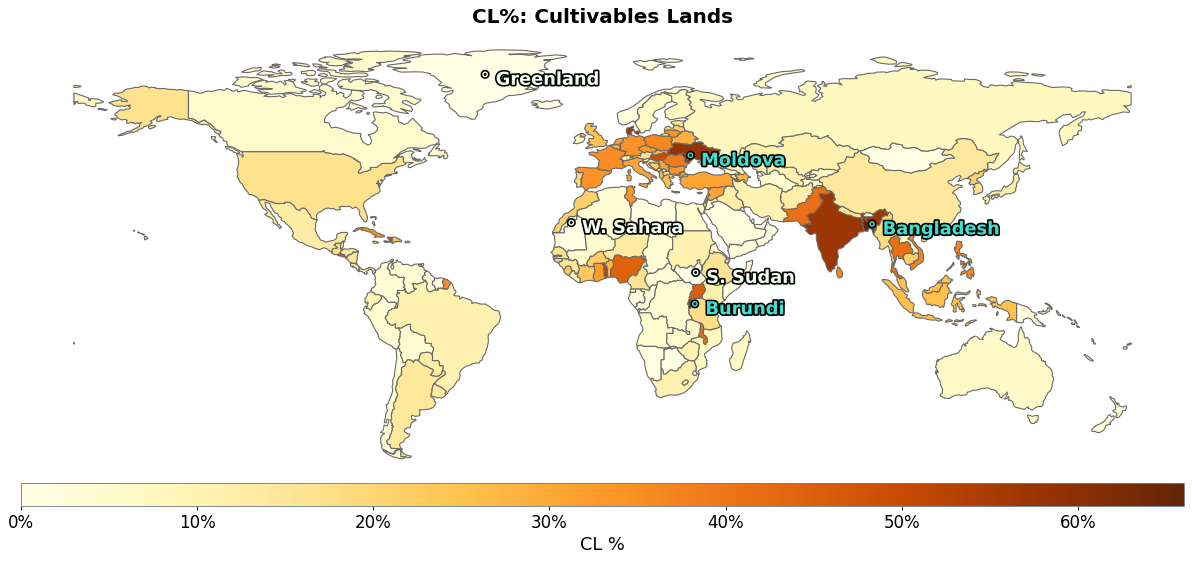

In [2]:
# VI

%matplotlib inline
plt.style.use('seaborn-deep')
plt.rcParams.update({'xtick.labelsize':15, 
                     'ytick.labelsize':15,
                     'ytick.labelleft':'off',
                     'ytick.labelright':'off',
                     'xtick.labelbottom':'off',
                     'axes.spines.left': False,
                     'axes.spines.bottom' : False,
                     'axes.spines.top': False,
                     'axes.spines.right':False,
                     'ytick.left':False,
                     'xtick.bottom':False,
                     'axes.labelsize':16,
                     'axes.grid':False,
                     'axes.edgecolor':'slategrey'
                        })
    
fig, ax1 = plt.subplots(1, 1, figsize=(15, 10), dpi=80)

divider = make_axes_locatable(ax1)

# Legend bar
cax = divider.append_axes("bottom", size="5%", pad=0.05)

# Plot
ax1 = wlands.plot(column='CL%',
                  ax=ax1,
                  legend=True,
                  edgecolor='dimgray',
                  cmap = 'YlOrBr',
                  cax=cax,
                  legend_kwds={'label': "CL %",
                             'orientation': 'horizontal'}
                 )
                  

# Adding the percentage to the labels of the legend

def tick(ax):
    s = cax.get_xticks()
    labelc = []
    [labelc.append(str(int(s[n]))+'%') for n in range(len(s))]
    return ax.set_xticklabels(labelc)
        
tick(cax)

# Selecting the countries to show,

dclwmn = pd.concat([wlands.sort_values(by='CL%').tail(3),
                    wlands.sort_values(by='CL%').head(3)]).reset_index(drop=True)

dclwmn['geops'] = gpd.GeoDataFrame(geometry = gpd.points_from_xy(dclwmn['geometry'].centroid.x, 
                                                                 dclwmn['geometry'].centroid.y),
                                                                   crs = "EPSG:4326")
                  
# Adding the names of the selected countries,

for place in range(dclwmn.shape[0]):
        if place < 3:
            color = 'turquoise' 
        else:
            color = 'honeydew'
        ax1.text(dclwmn.geops[place].x,
                 dclwmn.geops[place].y-3,
                 '\u00B0' + ' ' + dclwmn.loc[place,'name_w'],
                 fontsize = 16,
                 fontweight = 'bold',
                 color = color,
                 path_effects=[path_effects.Stroke(linewidth=3, foreground='black'),
                           path_effects.Normal()])
                  
ax1.set_title('CL%: Cultivables Lands', fontsize=18, fontweight = 'bold')
plt.tight_layout()
plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/CL.png', bbox_inches='tight')

plt.show()
